In [1]:
from pandas import read_csv
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import shapely.wkt
import geopandas as gpd
import contextily as cx
import constants as c
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')

In [2]:
synthfirm_all = read_csv('outputs_SF/synthetic_firms.csv')
sf_map = gpd.read_file('inputs_SF/SFBay_freight.geojson')
mesozone_id_lookup = read_csv('inputs_SF/zonal_id_lookup_final.csv')

lehd_validation = read_csv('inputs_SF/LEHD_employment.csv')
synthfirm_output = read_csv('outputs_SF/processed_b2b_flow_summary_mesozone.csv')
sf_map.head(5)

,GEOID,CBPZONE,MESOZONE,geometry
0,060411242004,6041,3751.0,"MULTIPOLYGON (((-122.48795 37.89798, -122.4859..."
1,060510001011,6051,4047.0,"MULTIPOLYGON (((-118.94774 37.77604, -118.9459..."
2,060930002001,6093,8981.0,"MULTIPOLYGON (((-122.25152 41.75726, -122.2491..."
3,060570009003,6057,4462.0,"MULTIPOLYGON (((-120.85050 39.39899, -120.8491..."
4,060750108001,6075,5684.0,"MULTIPOLYGON (((-122.41684 37.79660, -122.4119..."


In [3]:
# calculate land area
sf_map.loc[:, "area"] = sf_map['geometry'].to_crs({'proj':'cea'}).map(lambda p: p.area / 10**6) 
# sf_map.loc[:, "area"] = sf_map.area/ 10**6 # km^2
sf_map.head(5)

,GEOID,CBPZONE,MESOZONE,geometry,area
0,060411242004,6041,3751.0,"MULTIPOLYGON (((-122.48795 37.89798, -122.4859...",2.303287
1,060510001011,6051,4047.0,"MULTIPOLYGON (((-118.94774 37.77604, -118.9459...",2977.822080
2,060930002001,6093,8981.0,"MULTIPOLYGON (((-122.25152 41.75726, -122.2491...",1372.744148
3,060570009003,6057,4462.0,"MULTIPOLYGON (((-120.85050 39.39899, -120.8491...",1032.663636
4,060750108001,6075,5684.0,"MULTIPOLYGON (((-122.41684 37.79660, -122.4119...",0.092171


In [6]:
print(synthfirm_all.columns)
firm_by_zone = synthfirm_all.groupby(['MESOZONE']).agg({'BusID':'count',
                                                       'Emp':'sum'})
firm_by_zone = firm_by_zone.reset_index()
firm_by_zone.columns = ['MESOZONE', 'firm_count', 'employment_count']
firm_by_zone.head(5)

print(firm_by_zone[['firm_count', 'employment_count']].sum())

Index(['CBPZONE', 'FAFZONE', 'esizecat', 'Industry_NAICS6_Make',
       'Commodity_SCTG', 'Emp', 'BusID', 'MESOZONE'],
      dtype='object')
firm_count          8.390414e+06
employment_count    1.075726e+08
dtype: float64


In [7]:
print(mesozone_id_lookup.columns)
firm_by_zone = pd.merge(firm_by_zone, mesozone_id_lookup, on = 'MESOZONE', how = 'left')
firm_by_zone.head(5)

Index(['Unnamed: 0', 'GEOID', 'CBPZONE', 'MESOZONE', 'FAFID', 'FAFNAME'], dtype='object')


,MESOZONE,firm_count,employment_count,Unnamed: 0,GEOID,CBPZONE,FAFID,FAFNAME
0,1,30,4498.258503,5072,60014001001,6001,64,San Francisco
1,2,34,255.635178,9148,60014002001,6001,64,San Francisco
2,3,48,351.784439,1029,60014002002,6001,64,San Francisco
3,4,34,975.381942,10526,60014003001,6001,64,San Francisco
4,5,32,343.366513,8963,60014003002,6001,64,San Francisco


In [8]:
firm_in_study_area = firm_by_zone.loc[firm_by_zone['FAFID'].isin([62, 64, 65, 69])]
print(firm_in_study_area.firm_count.sum())
# sf_map_with_firm = sf_map.merge(firm_in_austin, on='MESOZONE', how='inner')
# sf_map_with_firm.head(5)
synthfirm_in_study_area = synthfirm_all.loc[synthfirm_all['MESOZONE'] < 20000]
print(synthfirm_in_study_area.Emp.sum())
print(len(synthfirm_all.Industry_NAICS6_Make.unique()))
print(len(synthfirm_in_study_area.Industry_NAICS6_Make.unique()))

synthfirm_in_study_area.head(5)

421169
5827560.989253243
410
403


,CBPZONE,FAFZONE,esizecat,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE
123,6101,62,1,1111A0,3,1.000000,124,10044
124,6011,69,1,1111A0,3,1.000000,125,1313
1043,6067,62,1,1111A0,3,1.000000,1044,5509
1044,6113,62,1,1111A0,3,4.666667,1045,10462
1045,6113,62,1,1111A0,3,4.666667,1046,10451


5827560.989253243
25006.1 0.98


,County,LEHD employment,CBPZONE,SynthFirm employment
0,6001,613088.50,6001,653594.002016
1,6003,147.50,6003,44.000001
2,6005,6257.75,6005,5091.999933
3,6007,56102.75,6007,54320.000567
4,6009,5620.75,6009,5402.999965


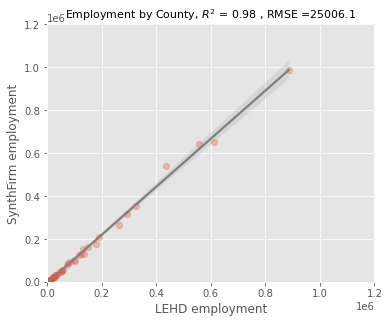

In [27]:
# compare to LEHD data
#lehd_validation.head(5)
lehd_firm_by_county = lehd_validation.loc[lehd_validation['industry'] == '0']
firm_in_study_area_by_county = firm_in_study_area.groupby('CBPZONE')[['employment_count']].sum()
firm_in_study_area_by_county = firm_in_study_area_by_county.reset_index()
# print(firm_in_study_area_by_county.head(5))

lehd_firm_by_county = lehd_firm_by_county.groupby('geography')[['EmpS']].mean()
lehd_firm_by_county = lehd_firm_by_county.reset_index()
# print(lehd_firm_by_county.head(5))
firm_comparison_by_county = pd.merge(lehd_firm_by_county, 
                                     firm_in_study_area_by_county,
                                     left_on = 'geography',
                                     right_on = 'CBPZONE',
                                     how = 'inner')
firm_comparison_by_county.columns = ['County', 'LEHD employment', 'CBPZONE', 'SynthFirm employment']
rmse_emp = mean_squared_error(firm_comparison_by_county['LEHD employment'], 
                              firm_comparison_by_county['SynthFirm employment'], squared = False)
r2_emp = r2_score(firm_comparison_by_county['LEHD employment'], 
                  firm_comparison_by_county['SynthFirm employment'])
rmse_emp = np.round(rmse_emp, 1)
r2_emp = np.round(r2_emp, 2)
print(firm_comparison_by_county['SynthFirm employment'].sum())
print(rmse_emp, r2_emp)
plt.style.use('ggplot')
g = sns.lmplot(
    data=firm_comparison_by_county,
    x="LEHD employment", y="SynthFirm employment", 
    height=4.5, aspect = 1.2, line_kws={'color': 'grey'}, scatter_kws = {'alpha':0.3})
plt.xlim([0, 1200000])
plt.ylim([0, 1200000])
plt.title('Employment by County, $R^{2}$ = ' + str(r2_emp) + ' , RMSE =' + str(rmse_emp), fontsize = 11)
plt.savefig('plots_SF/emp_by_county_validation.png', dpi = 200,
           bbox_inches = 'tight')

firm_comparison_by_county.head(5)

5425064.5
5827560.989253243


/var/folders/w6/7qcyt43n21ddydhdfdslrp7c0000gp/T/ipykernel_31761/3262073820.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'] = synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'].astype(str)
/var/folders/w6/7qcyt43n21ddydhdfdslrp7c0000gp/T/ipykernel_31761/3262073820.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synthfirm_in_study_area.loc[:, 'NAICS2'] = synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'].str[:2]
/var/folders/w6/7qcyt43n

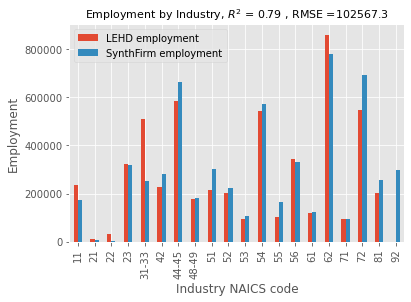

In [28]:
# compare to LEHD data
#lehd_validation.head(5)
industry_lookup = {'11':'11', '21':'21', '22':'22', '23':'23',
                   '31':'31-33', '32':'31-33', '33':'31-33',
                   '42':'42', '44':'44-45', '45':'44-45', '4A': '44-45',
                   '48':'48-49', '49':'48-49', '51':'51',
                   '52':'52', '53':'53', '54':'54', '55':'55',
                   '56':'56', '61':'61', '62':'62', '71':'71',
                   '72':'72', '81':'81', '92':'92', 'S0': '92'}
selected_counties = firm_comparison_by_county.County.unique()
lehd_firm_by_industry = lehd_validation.loc[lehd_validation['industry'] != '0']

# print(lehd_firm_by_industry.industry.unique())

lehd_firm_by_industry = lehd_firm_by_industry.groupby(['geography', 'industry'])[['EmpS']].mean()

lehd_firm_by_industry = lehd_firm_by_industry.reset_index()
lehd_firm_by_industry = \
lehd_firm_by_industry.loc[lehd_firm_by_industry['geography'].isin(selected_counties)]

lehd_firm_by_industry = lehd_firm_by_industry.groupby(['industry'])[['EmpS']].sum()
print(lehd_firm_by_industry['EmpS'].sum())

print(synthfirm_in_study_area.loc[:, 'Emp'].sum())
synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'] = synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'].astype(str)
synthfirm_in_study_area.loc[:, 'NAICS2'] = synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'].str[:2]
# print(synthfirm_in_study_area.loc[:, 'NAICS2'].unique())
synthfirm_in_study_area.loc[:, 'industry'] = synthfirm_in_study_area.loc[:, 'NAICS2'].map(industry_lookup)

firm_in_study_area_by_industry = synthfirm_in_study_area.groupby(['industry'])[['Emp']].sum()
# print(firm_in_study_area_by_industry['Emp'].sum())
firm_in_study_area_by_industry = firm_in_study_area_by_industry.reset_index()
firm_comparison_by_industry = pd.merge(lehd_firm_by_industry,
                                       firm_in_study_area_by_industry,
                                       on = 'industry', how = 'inner')

firm_comparison_by_industry.columns = ['Industry', 'LEHD employment',  'SynthFirm employment']
rmse_emp = mean_squared_error(firm_comparison_by_industry['LEHD employment'], 
                              firm_comparison_by_industry['SynthFirm employment'], squared = False)
r2_emp = r2_score(firm_comparison_by_industry['LEHD employment'], 
                  firm_comparison_by_industry['SynthFirm employment'])
rmse_emp = np.round(rmse_emp, 1)
r2_emp = np.round(r2_emp, 2)

# print(firm_comparison_by_industry['SynthFirm employment'].sum())
# print(firm_comparison_by_industry.head(5))
plt.style.use('ggplot')
firm_comparison_by_industry.plot(kind = 'bar',
    x="Industry")
plt.xlabel('Industry NAICS code')
plt.ylabel('Employment')
plt.title('Employment by Industry, $R^{2}$ = ' + str(r2_emp) + ' , RMSE =' + str(rmse_emp), fontsize = 11)
plt.savefig('plots_SF/emp_by_industry_validation.png', dpi = 200, bbox_inches = 'tight')

In [21]:
firm_in_region = firm_by_zone.loc[firm_by_zone['FAFID'].isin([64])]
sf_map_with_firm = sf_map.merge(firm_in_region, on='MESOZONE', how='inner')
sf_map_with_firm.loc[:, 'firm_per_area'] = sf_map_with_firm.loc[:, 'firm_count'] / sf_map_with_firm.loc[:, 'area']
sf_map_with_firm.loc[:, 'emp_per_area'] = sf_map_with_firm.loc[:, 'employment_count'] / sf_map_with_firm.loc[:, 'area']
sf_map_with_firm.head(5)

,GEOID_x,CBPZONE_x,MESOZONE,geometry,area,firm_count,employment_count,Unnamed: 0,GEOID_y,CBPZONE_y,FAFID,FAFNAME,firm_per_area,emp_per_area
0,060411242004,6041,3751.0,"MULTIPOLYGON (((-122.48795 37.89798, -122.4859...",2.303287,68,596.351212,0,60411242004,6041,64,San Francisco,29.523022,258.913086
1,060750108001,6075,5684.0,"MULTIPOLYGON (((-122.41684 37.79660, -122.4119...",0.092171,68,1275.957857,4,60750108001,6075,64,San Francisco,737.756094,13843.318896
2,060014227001,6001,394.0,"MULTIPOLYGON (((-122.24986 37.86749, -122.2484...",0.184157,37,594.606344,7,60014227001,6001,64,San Francisco,200.915769,3228.805163
3,060750611002,6075,6224.0,"MULTIPOLYGON (((-122.40790 37.79406, -122.4048...",0.054842,66,5034.008539,8,60750611002,6075,64,San Francisco,1203.454194,91790.889225
4,060855094013,6085,8378.0,"MULTIPOLYGON (((-122.11699 37.40350, -122.1157...",0.188182,45,533.376781,9,60855094013,6085,64,San Francisco,239.130683,2834.372310


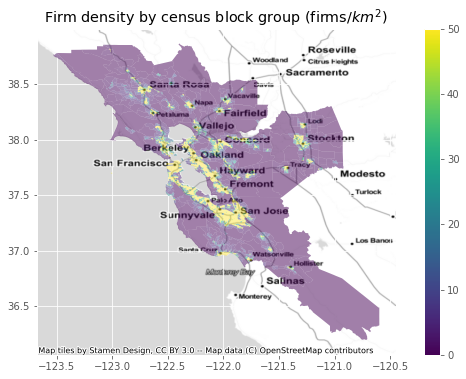

In [29]:
ax = sf_map_with_firm.plot(figsize = (10,6), column = 'firm_per_area', 
                           vmin=0, vmax=50, alpha = 0.5, legend=True)
cx.add_basemap(ax, crs = 'EPSG:4326', source = cx.providers.Stamen.TonerLite)
plt.title('Firm density by census block group (firms/$km^{2}$)')
plt.savefig('plots_SF/region_firm_count.png', dpi = 200)

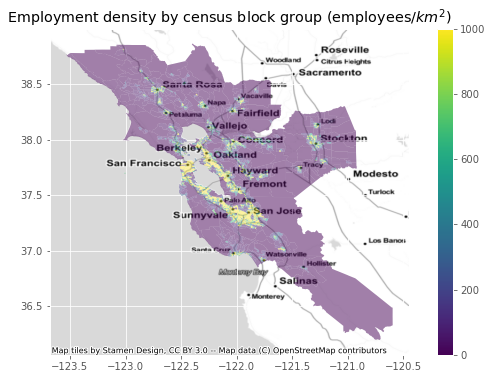

In [30]:
ax = sf_map_with_firm.plot(figsize = (10,6), column = 'emp_per_area', 
                            vmin=0, vmax=1000, alpha = 0.5, legend=True)
cx.add_basemap(ax, crs = 'EPSG:4326',source = cx.providers.Stamen.TonerLite)
plt.title('Employment density by census block group (employees/$km^{2}$)')
plt.savefig('plots_SF/region_emp_count.png', dpi = 200)

In [4]:
# plot production
print(synthfirm_output.columns)
production_in_region = synthfirm_output.loc[synthfirm_output['orig_FAFID'].isin([64])]
production_in_region = production_in_region.groupby(['SellerZone'])[['ShipmentLoad']].sum()
production_in_region = production_in_region.reset_index()
production_in_region = production_in_region.rename(columns = {'SellerZone': 'MESOZONE'})

sf_map_with_production = sf_map.merge(production_in_region, on='MESOZONE', how='inner')
sf_map_with_production.loc[:, 'production_per_area'] = \
sf_map_with_production.loc[:, 'ShipmentLoad'] * 0.907185/ \
sf_map_with_production.loc[:, 'area']
# sf_map_with_firm.loc[:, 'emp_per_area'] = sf_map_with_firm.loc[:, 'employment_count'] / sf_map_with_firm.loc[:, 'area']
sf_map_with_production.head(5)

Index(['Unnamed: 0', 'SellerZone', 'orig_FAFID', 'orig_FAFNAME', 'BuyerZone',
       'dest_FAFID', 'dest_FAFNAME', 'SCTG_Group', 'SCTG_Name', 'mode_choice',
       'tmiles', 'ShipmentLoad', 'count', 'outbound', 'inbound', 'Distance'],
      dtype='object')


,GEOID,CBPZONE,MESOZONE,geometry,area,ShipmentLoad,production_per_area
0,060411242004,6041,3751.0,"MULTIPOLYGON (((-122.48795 37.89798, -122.4859...",2.303287,0.544544,0.214477
1,060750108001,6075,5684.0,"MULTIPOLYGON (((-122.41684 37.79660, -122.4119...",0.092171,202.444404,1992.533031
2,060750611002,6075,6224.0,"MULTIPOLYGON (((-122.40790 37.79406, -122.4048...",0.054842,61.589786,1018.802936
3,060855094013,6085,8378.0,"MULTIPOLYGON (((-122.11699 37.40350, -122.1157...",0.188182,1.215518,5.859764
4,060750128004,6075,5737.0,"MULTIPOLYGON (((-122.44730 37.79846, -122.4426...",0.065749,44.106737,608.569629


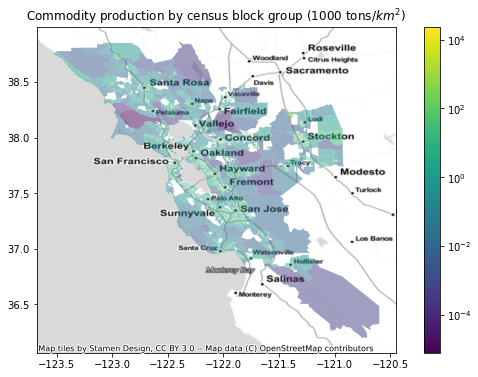

In [5]:
ax = sf_map_with_production.plot(figsize = (10,6), column = 'production_per_area', 
                            alpha = 0.5, legend=True,
                            norm=matplotlib.colors.LogNorm(vmin=sf_map_with_production.production_per_area.min(), 
                                                           vmax=sf_map_with_production.production_per_area.max()))
cx.add_basemap(ax, crs = 'EPSG:4326',source = cx.providers.Stamen.TonerLite)
plt.title('Commodity production by census block group (1000 tons/$km^{2}$)')
plt.savefig('plots_SF/region_production_allmodes.png', dpi = 200)

In [6]:
# print(synthfirm_output.columns)
attraction_in_region = synthfirm_output.loc[synthfirm_output['dest_FAFID'].isin([64])]
attraction_in_region = attraction_in_region.groupby(['BuyerZone'])[['ShipmentLoad']].sum()
attraction_in_region = attraction_in_region.reset_index()
attraction_in_region = attraction_in_region.rename(columns = {'BuyerZone': 'MESOZONE'})

sf_map_with_attraction = sf_map.merge(attraction_in_region, on='MESOZONE', how='inner')
sf_map_with_attraction.loc[:, 'attraction_per_area'] = \
sf_map_with_attraction.loc[:, 'ShipmentLoad'] * 0.907185/ \
sf_map_with_attraction.loc[:, 'area']
# sf_map_with_firm.loc[:, 'emp_per_area'] = sf_map_with_firm.loc[:, 'employment_count'] / sf_map_with_firm.loc[:, 'area']
sf_map_with_attraction.head(5)

,GEOID,CBPZONE,MESOZONE,geometry,area,ShipmentLoad,attraction_per_area
0,060411242004,6041,3751.0,"MULTIPOLYGON (((-122.48795 37.89798, -122.4859...",2.303287,18.524643,7.296215
1,060750108001,6075,5684.0,"MULTIPOLYGON (((-122.41684 37.79660, -122.4119...",0.092171,253.765728,2497.656575
2,060014227001,6001,394.0,"MULTIPOLYGON (((-122.24986 37.86749, -122.2484...",0.184157,41.300247,203.451460
3,060750611002,6075,6224.0,"MULTIPOLYGON (((-122.40790 37.79406, -122.4048...",0.054842,151.315946,2503.030763
4,060855094013,6085,8378.0,"MULTIPOLYGON (((-122.11699 37.40350, -122.1157...",0.188182,41.376856,199.469335


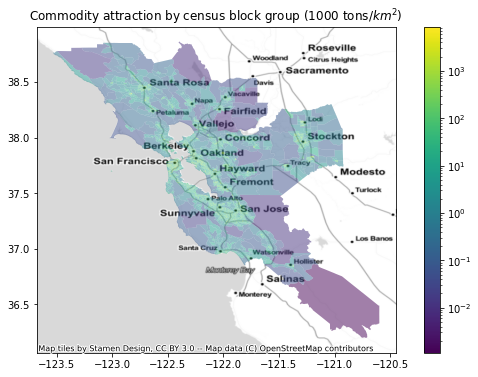

In [7]:
ax = sf_map_with_attraction.plot(figsize = (10,6), column = 'attraction_per_area', 
                            alpha = 0.5, legend=True,
                            norm=matplotlib.colors.LogNorm(vmin=sf_map_with_attraction.attraction_per_area.min(), 
                                                           vmax=sf_map_with_attraction.attraction_per_area.max()))
cx.add_basemap(ax, crs = 'EPSG:4326',source = cx.providers.Stamen.TonerLite)
plt.title('Commodity attraction by census block group (1000 tons/$km^{2}$)')
plt.savefig('plots_SF/region_attraction_allmodes.png', dpi = 200)